# YOLOv3 모델 (TensorFlow)

- 코드: https://github.com/zzh8829/yolov3-tf2

### 모델 다운로드

In [5]:
# 기존의 tensorflow와 keras 삭제
!pip uninstall -y tensorflow keras

Found existing installation: tensorflow 2.8.0
Uninstalling tensorflow-2.8.0:
  Successfully uninstalled tensorflow-2.8.0
Found existing installation: keras 2.8.0
Uninstalling keras-2.8.0:
  Successfully uninstalled keras-2.8.0


In [6]:
# YOLOv3 클론 후, 파일 위치로 이동하여 설치
# 그 외에 필요한 tensorflow 등 설치
!git clone https://github.com/zzh8829/yolov3-tf2
%cd yolov3-tf2/
!pip install tensorflow==2.8.0
!pip install opencv-python==4.5.5.64
!pip install lxml
!pip install tqdm
!pip install keras==2.8.0

fatal: destination path 'yolov3-tf2' already exists and is not an empty directory.
/content/yolov3-tf2/yolov3-tf2/yolov3-tf2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tensorflow-2.8.0-cp310-cp310-manylinux2010_x86_64.whl (497.6 MB)
  Using cached keras-2.8.0-py2.py3-none-any.whl (1.4 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 MB 13.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.7.0.72
    Uninstalling opencv-python-4.7.0.72:
      Successfully uninstalled opencv-python-4.7.0.72
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/c

### 모델 파일 변환

DarkNet의 모델파일을 Keras에서 사용할 수 있는 모델 파일로 변환
- `convert.py`: 변환 실행 파일
- `yolov3.weight`: Darknet으로 학습된 모델 파일
- `yolov3.tf`: Keras Yolov3 모델


* Yolov3 Weight: https://pjreddie.com/media/files/yolov3.weights

In [14]:
# 기존의 DarkNet의 모델 파일을 Tensorflow 모델 파일로 변환
!wget https://pjreddie.com/media/files/yolov3.weights -O data/yolov3.weights
!python convert.py --weights ./data/yolov3.weights --output ./checkpoints/yolov3.tf

--2023-05-01 09:43:16--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘data/yolov3.weights’

data/yolov3.weights 100%[===================>] 236.52M  18.6MB/s    in 14s     

2023-05-01 09:43:31 (17.2 MB/s) - ‘data/yolov3.weights’ saved [248007048/248007048]

Model: "yolov3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                      

### Detector

In [10]:
import time
import cv2
import numpy as np
import tensorflow as tf

from yolov3_tf2.models import YoloV3
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs
from absl import app, logging, flags
from absl.flags import FLAGS

from keras.preprocessing import image
import matplotlib.pyplot as plt
from IPython.display import Image, display

In [11]:
# flags 정의 및 사용
flags.DEFINE_string('classes', './data/coco.names', 'classes file')
flags.DEFINE_string('weights', './checkpoints/yolov3.tf', 'weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_string('image', './data/girl.png', 'input image')
flags.DEFINE_string('tfrecord', None, 'tfrecord')
flags.DEFINE_string('output', './output.jpg', 'output image')
flags.DEFINE_integer('num_classes', 80, 'number of classes')

app._run_init(['yolov3'], app.parse_flags_with_usage)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [15]:
# YOLO 객체 정의 및 클래스 이름 정의
yolo = YoloV3(classes=FLAGS.num_classes)
yolo.load_weights(FLAGS.weights).expect_partial()
class_names = [c.strip() for c in open(FLAGS.classes).readlines()]

In [16]:
# 클래스 이름 출력
print(class_names)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [17]:
# 사용할 Detector 정의
def detector():
    # 이미지 열기
    img_raw = tf.image.decode_image(open(FLAGS.image, 'rb').read(), channels=3) # 컬러 이미지이므로 3

    # Dimension을 추가하여 입력할 수 있는 모양으로 변환
    img = tf.expand_dims(img_raw, 0)

    # 이미지 사이즈 변환
    img = transform_images(img, FLAGS.size)

    # YOLO 모델로부터 boxes, scores, classes, nums 반환
    t1 = time.time()
    boxes, scores, classes, nums = yolo(img)
    t2 = time.time()
    print('time: {}'.format(t2 - t1)) # YOLO 수행 시간 측정

    # 반복하면서 최종 결과(boxes, scores, classes, nums)를 전체 갯수만큼 반환
    for i in range(nums[0]):
        print('{}, {}, {}'.format(class_names[int(classes[0][i])],
                                  np.array(scores[0][i]),
                                  np.array(boxes[0][i])))
    
    # 사용할 이미지를 numpy 변환 및 OpenCV를 위해 RGB를 BGR로 되도록 변환
    img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)

    # 이미지 출력
    img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

    return img

In [18]:
# 예제 데이터 확인
!ls data

checkpoint  girl.png	meme.jpg      street.jpg      voc2012.names
coco.names  meme2.jpeg	meme_out.jpg  street_out.jpg  yolov3.weights


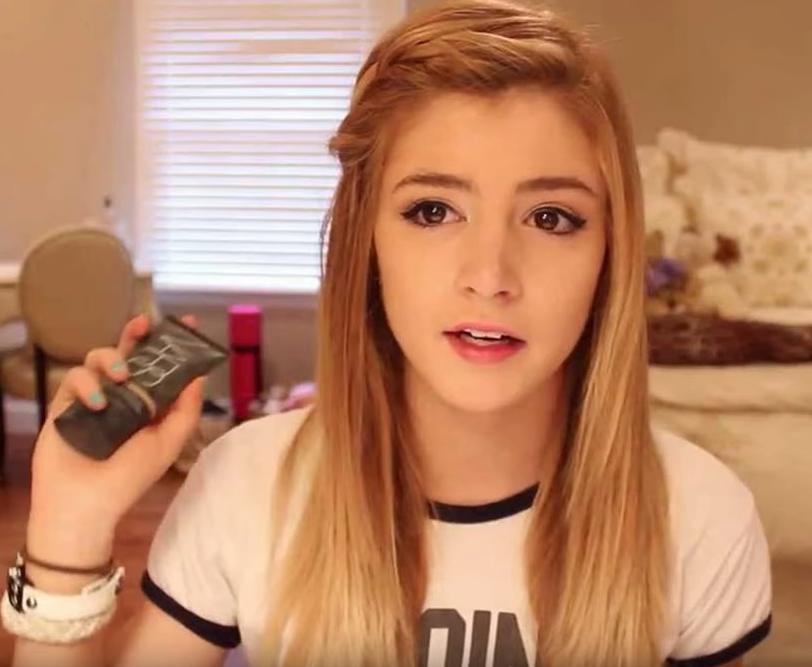

In [19]:
# 입력 사진 출력
FLAGS.image = 'data/girl.png'
Image(filename=FLAGS.image, width=500)

time: 0.11184906959533691
person, 0.9997697472572327, [0.06754467 0.03718698 0.967988   0.9650754 ]
chair, 0.9255480766296387, [0.0185187  0.34200275 0.17385134 0.62783295]


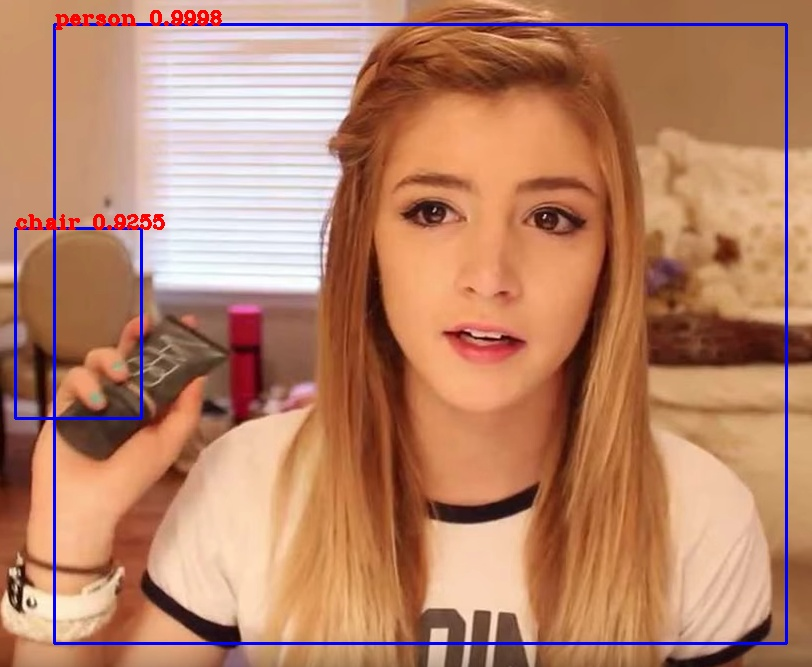

In [21]:
# 객체 인식한 결과 (person, chair)
output = detector()
display(Image(data=bytes(cv2.imencode('.jpg', output)[1]), width=500))

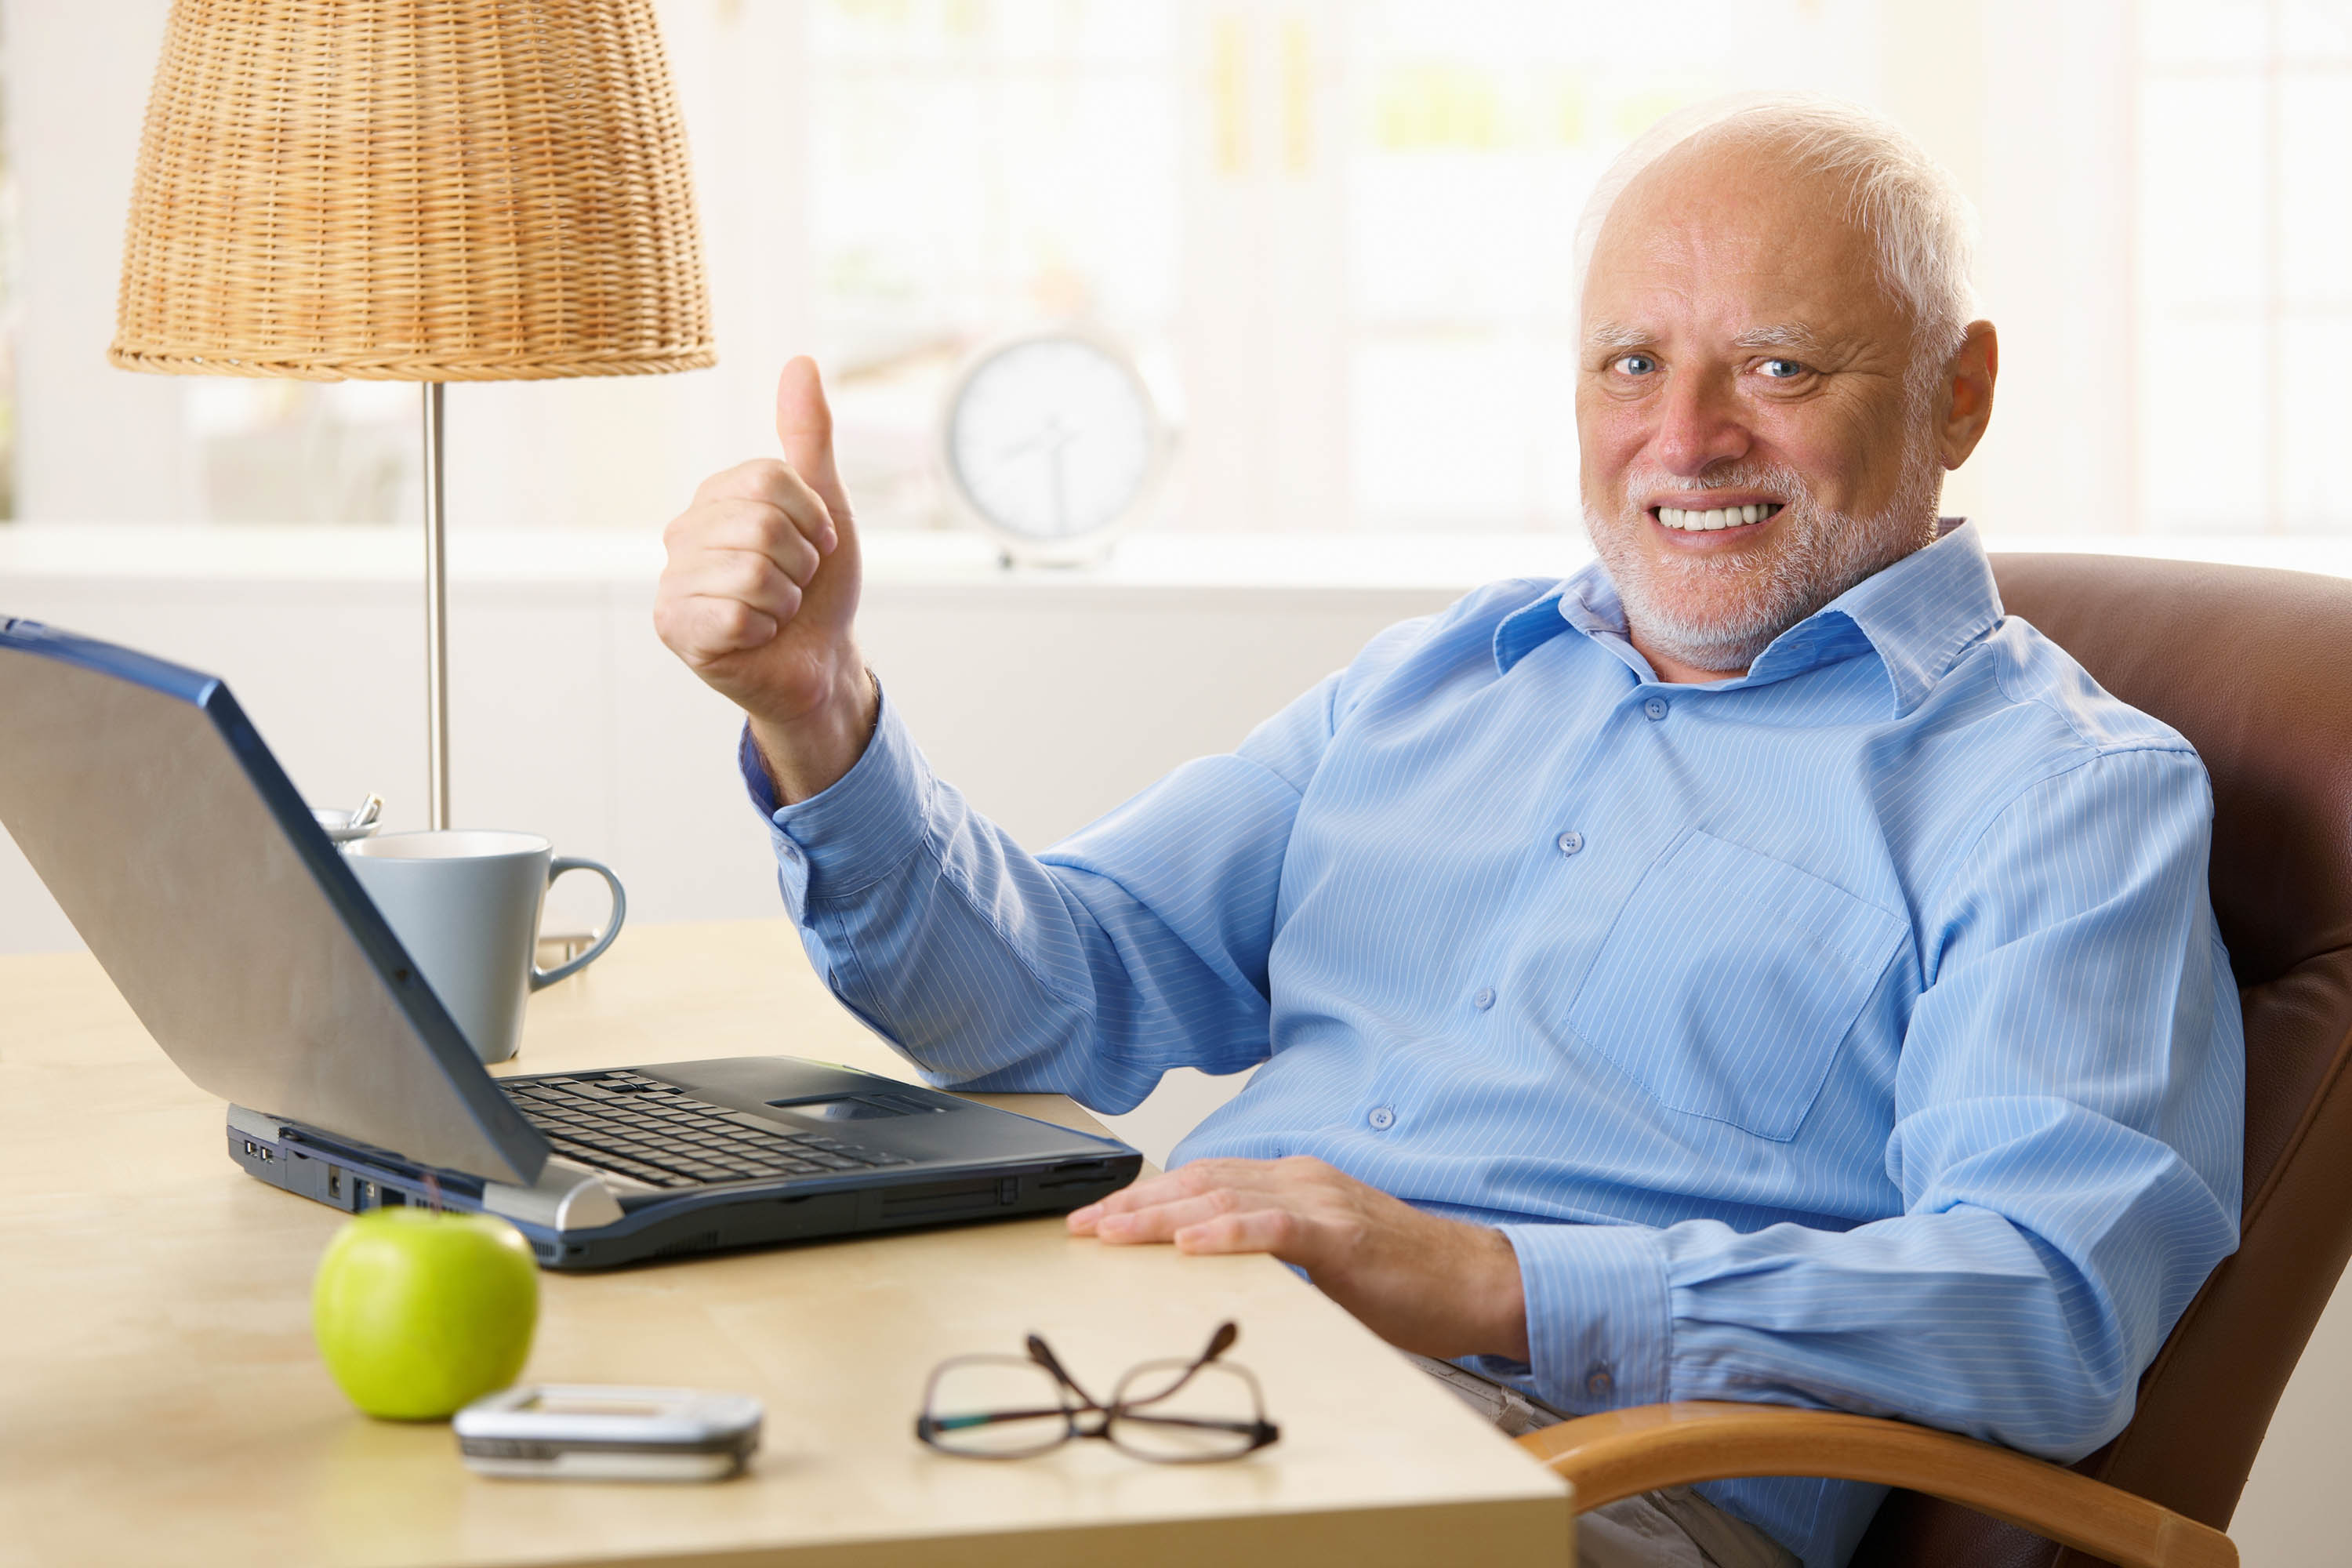

In [22]:
# 입력 사진 출력
FLAGS.image = 'data/meme.jpg'
Image(filename=FLAGS.image, width=1000)

time: 0.1080939769744873
cup, 0.9980731010437012, [0.14266218 0.52777606 0.27184254 0.65748256]
person, 0.9976975321769714, [0.2898291  0.09854648 0.95846486 0.9202168 ]
laptop, 0.9599869847297668, [-0.01710647  0.39493692  0.52297276  0.7962775 ]
apple, 0.9081628322601318, [0.13114463 0.77143586 0.22893356 0.90729535]
cell phone, 0.732137143611908, [0.18850097 0.87569416 0.3350185  0.9422209 ]
clock, 0.6700018048286438, [0.4010809  0.2124461  0.49267417 0.35021502]
cup, 0.5366387367248535, [0.15088229 0.52855617 0.25541586 0.66439587]
chair, 0.5001124739646912, [0.29507306 0.30677184 0.99988616 0.9955944 ]


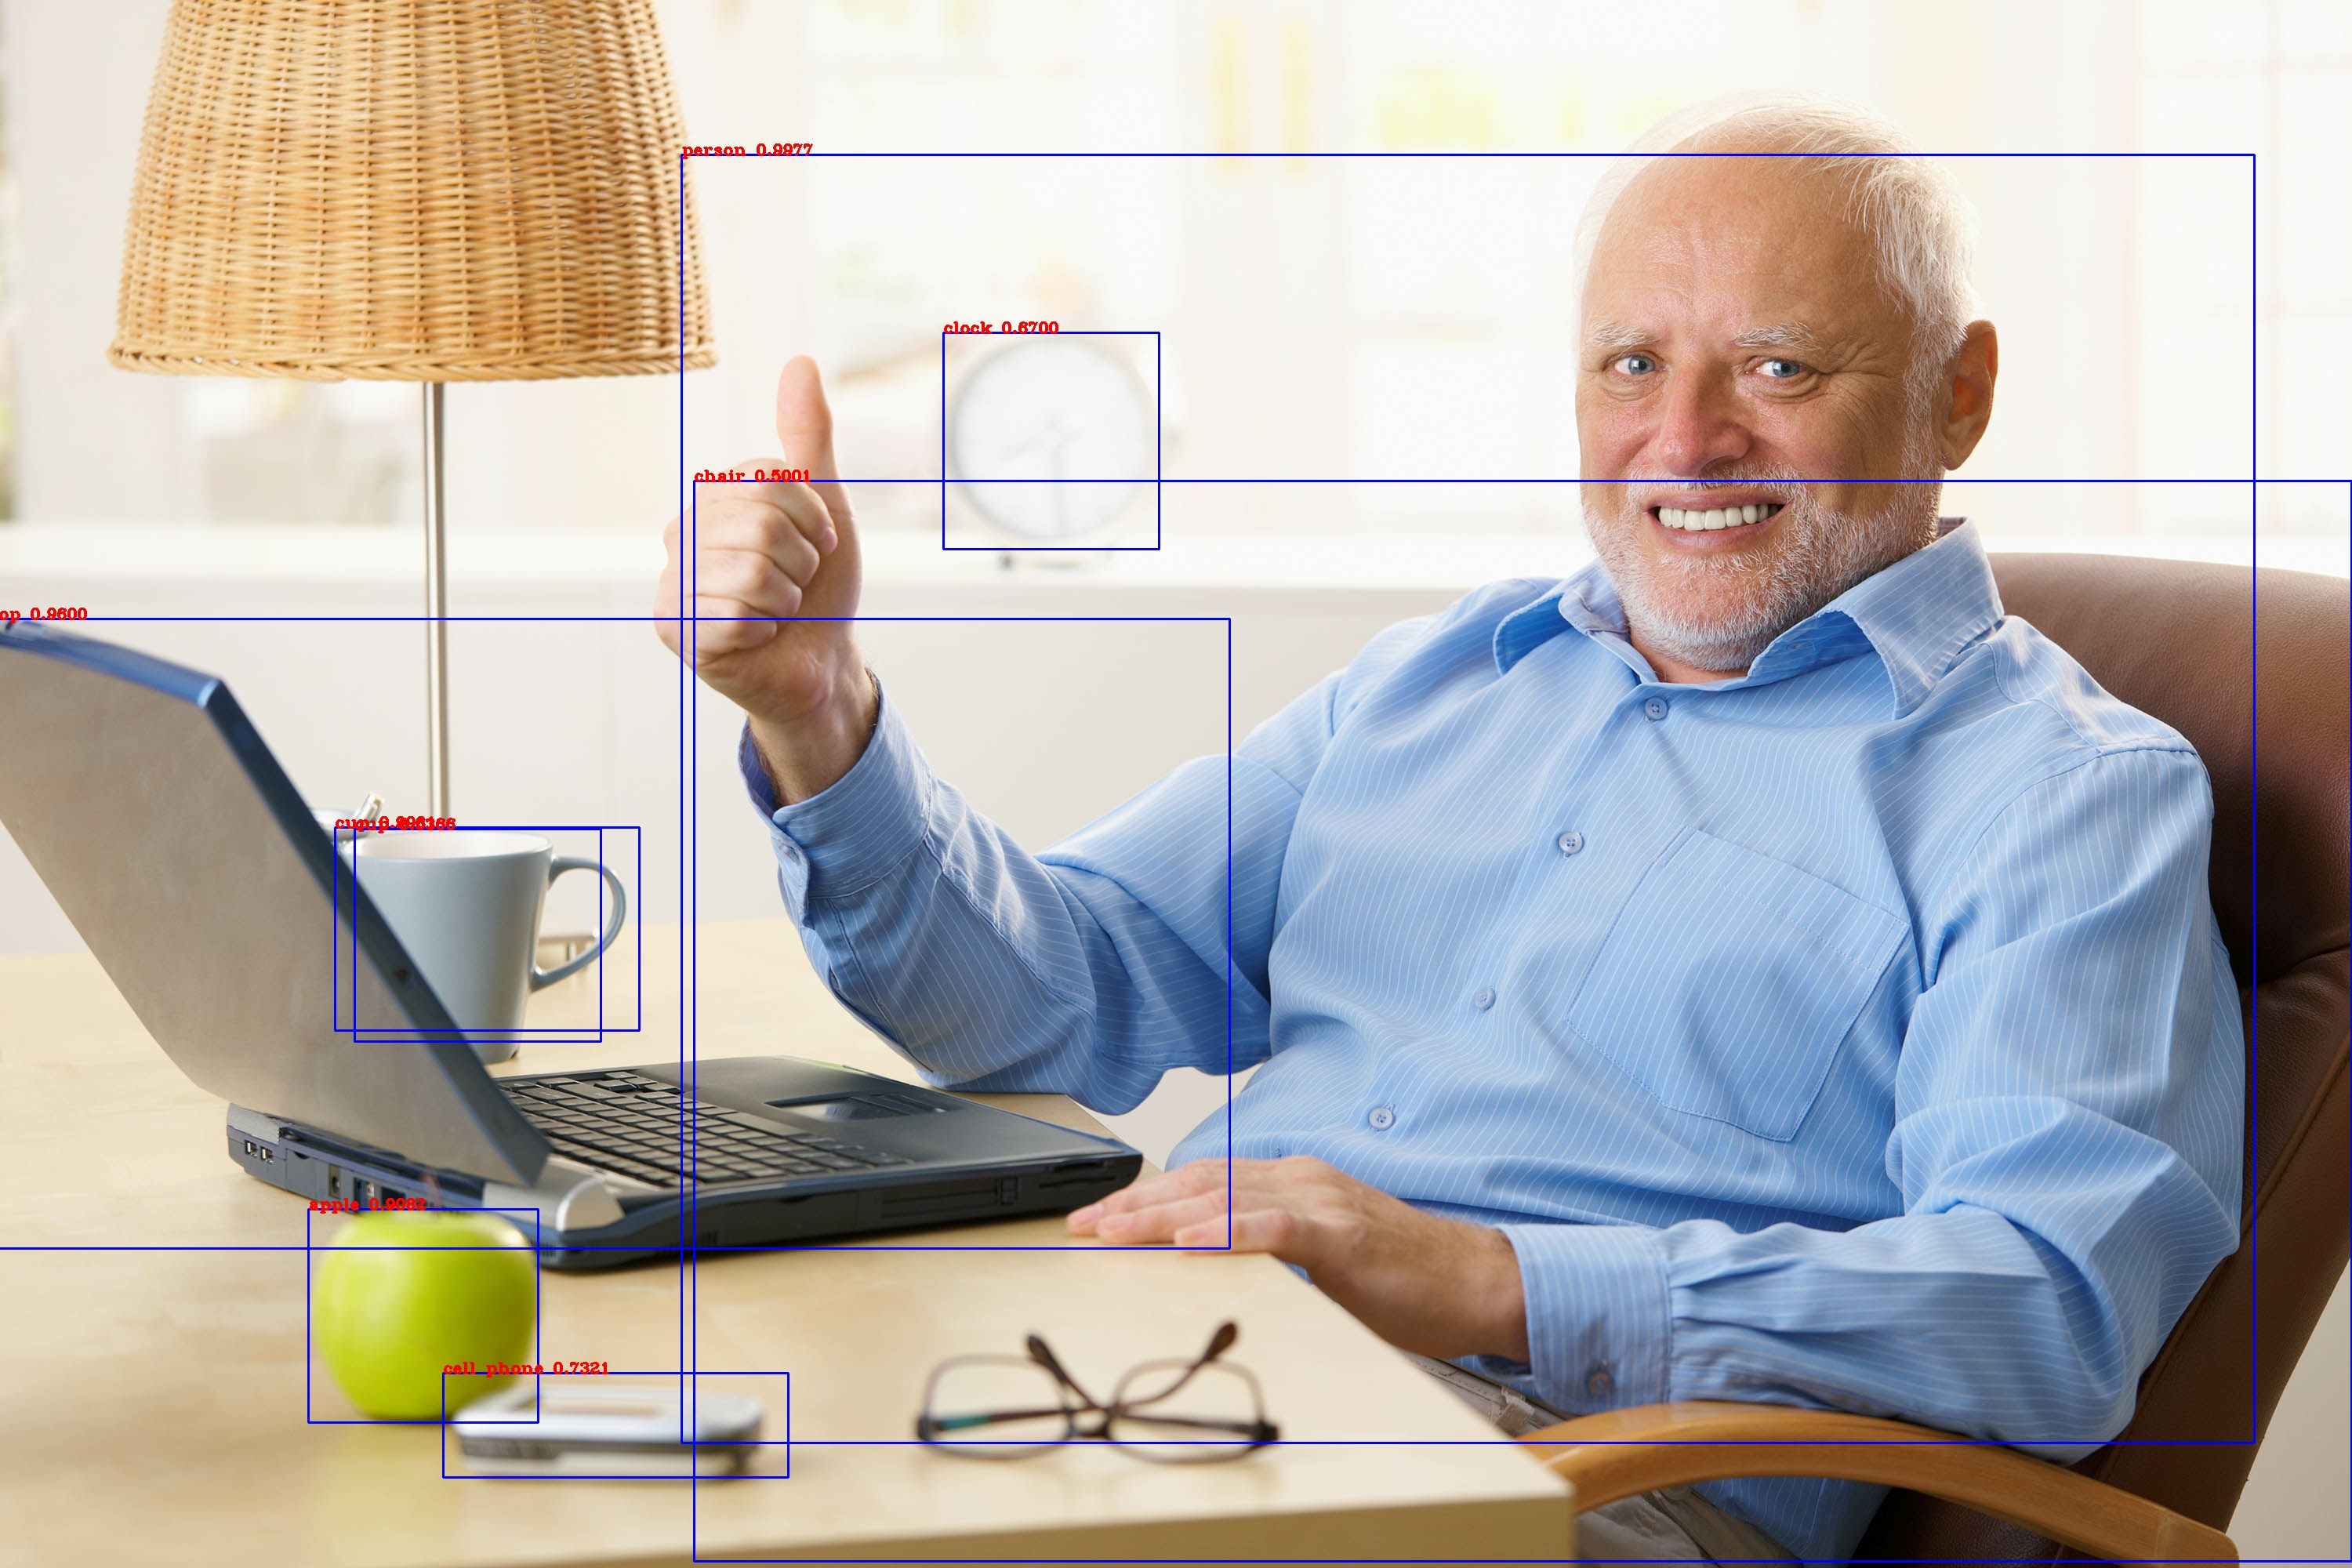

In [24]:
# 객체 인식한 결과 (cup, person, laptop, apple, cell phone, cloeck, chair)
output = detector()
display(Image(data=bytes(cv2.imencode('.jpg', output)[1]), width=1000))

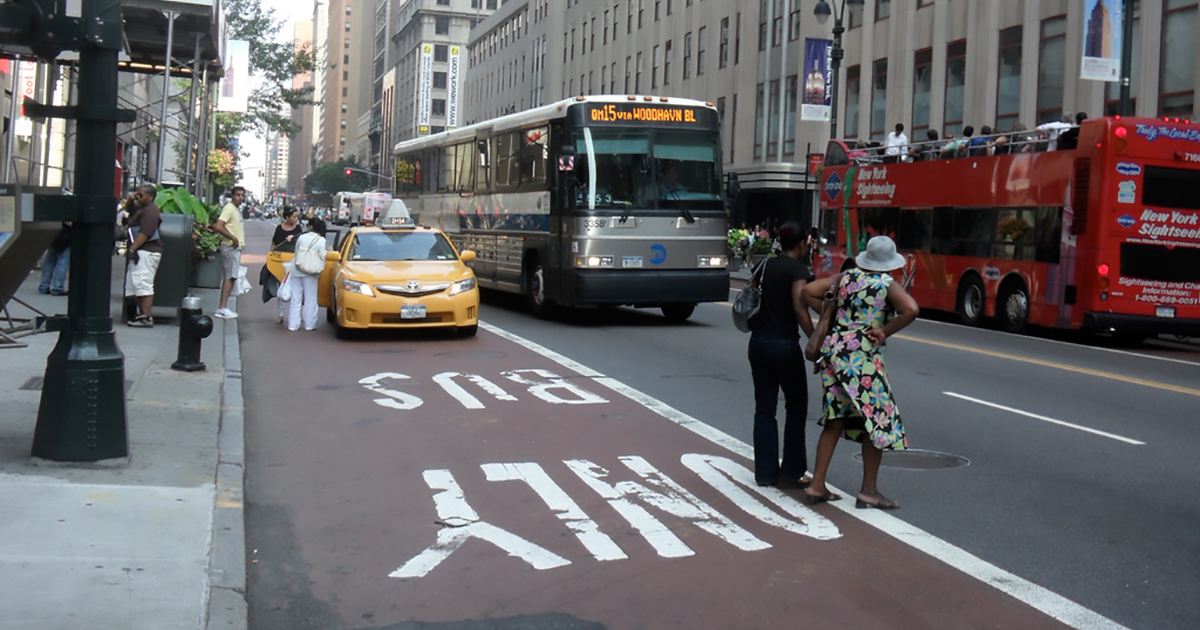

In [25]:
# 입력 사진 출력
FLAGS.image = 'data/street.jpg'
Image(filename=FLAGS.image, width=800)

time: 0.10692691802978516
car, 0.9966800212860107, [0.26270664 0.34669653 0.40587908 0.5401914 ]
bus, 0.9951198101043701, [0.67014587 0.17855003 0.9937171  0.5290146 ]
person, 0.9870267510414124, [0.6138847  0.3450544  0.68770576 0.7753    ]
bus, 0.9826598763465881, [0.3228875  0.15145977 0.6138201  0.506682  ]
person, 0.9748104810714722, [0.22922696 0.34322935 0.26619267 0.52385163]
person, 0.9731234908103943, [0.10603387 0.29673994 0.14109921 0.52050036]
person, 0.9698237776756287, [0.6745359  0.36693054 0.76731586 0.80656105]
person, 0.840420126914978, [0.73152274 0.19712627 0.76029474 0.2559415 ]
person, 0.7661858797073364, [0.14938346 0.30133063 0.20066255 0.5780297 ]
person, 0.6201273202896118, [0.8069899  0.19955893 0.82683456 0.24689196]
traffic light, 0.5584409832954407, [0.2863981  0.26624355 0.29791862 0.28726056]
bus, 0.5482760667800903, [0.2722816  0.10793351 0.6291896  0.4942211 ]
person, 0.5450270771980286, [0.62025    0.34034783 0.70120776 0.7859604 ]
person, 0.52716672

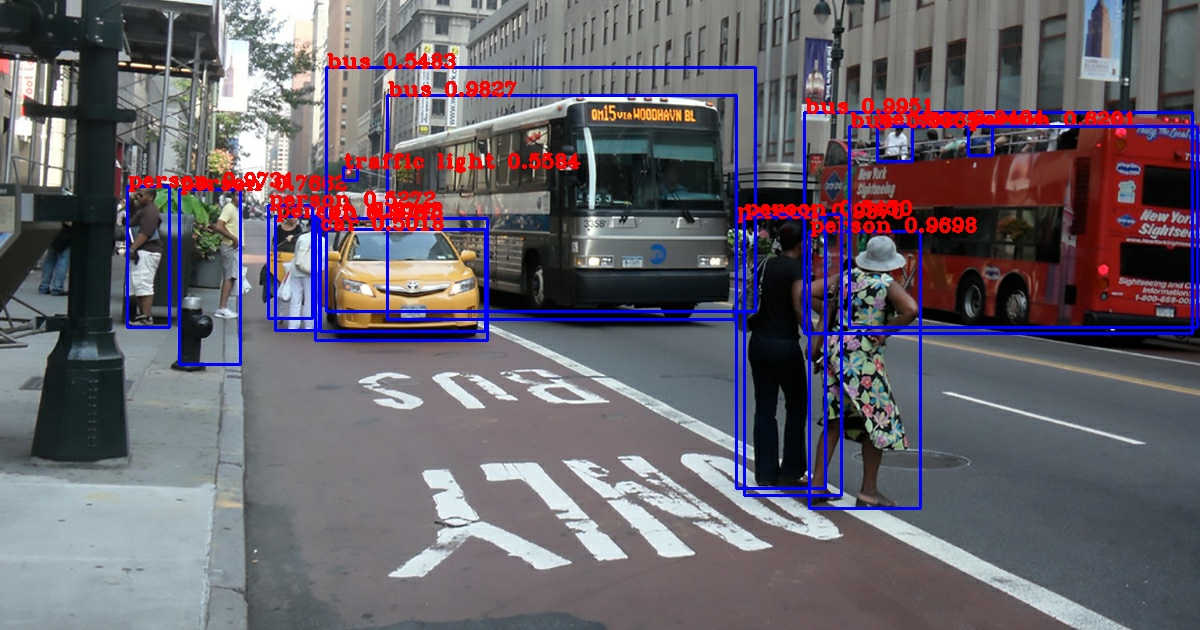

In [26]:
# 객체 인식한 결과 (car, bus, person, traffic light)
output = detector()
display(Image(data=bytes(cv2.imencode('.jpg', output)[1]), width=800))

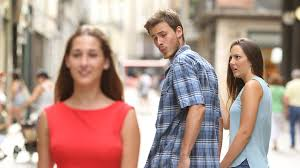

In [27]:
# 입력 사진 출력
FLAGS.image = 'data/meme2.jpeg'
Image(filename=FLAGS.image, width=400)

time: 0.10904312133789062
person, 0.9996726512908936, [0.10497867 0.17179066 0.47821975 0.99576527]
person, 0.9945406913757324, [0.4560235  0.06149828 0.7274452  0.98329866]
person, 0.9557744860649109, [0.706931   0.22946665 0.91559696 1.0209918 ]
person, 0.9102909564971924, [0.93971944 0.43444306 1.0022458  0.8968894 ]
person, 0.6195988655090332, [0.08753046 0.41167548 0.18400961 0.7732612 ]
person, 0.5340753793716431, [0.47825024 0.07239664 0.77431846 0.9673749 ]


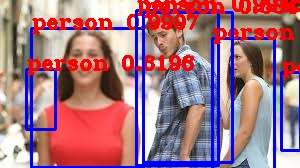

In [28]:
# 객체 인식한 결과 (person)
output = detector()
display(Image(data=bytes(cv2.imencode('.jpg', output)[1]), width=400))